<a href="https://colab.research.google.com/github/gc2321/ztm_pytorch/blob/main/miRNA_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score


In [2]:
print(torch.__version__)

2.5.0+cu121


In [3]:
torch.cuda.is_available()

True

In [4]:
# set uo device agnoistic code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# count number of devices
torch.cuda.device_count()

1


## Load Data

In [6]:
# mount the colab
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [7]:
import fileinput
filePath = "/content/gdrive/MyDrive/neural_data/miRNA_lung.csv"

In [8]:
data = pd.read_csv(filePath)

In [9]:
data.head()

,depmap_id,cell_line_display_name,lineage_1,lineage_2,lineage_3,lineage_5,lineage_6,lineage_4,MIMAT0000062,MIMAT0000063,...,MIMAT0002192,MIMAT0002191,MIMAT0002190,MIMAT0002189,MIMAT0002188,MIMAT0002187,MIMAT0002186,MIMAT0002185,MIMAT0010151,MIMAT0010150
0,ACH-000382,CORL24,Lung,Lung Neuroendocrine Tumor,Small Cell Lung Cancer,NaN,NaN,NaN,14.735474,12.091720,...,6.113534,6.609991,6.308885,6.262471,6.397461,5.966938,5.907852,6.572435,6.230741,6.910133
1,ACH-000187,CORL311,Lung,Lung Neuroendocrine Tumor,Small Cell Lung Cancer,NaN,NaN,NaN,14.088938,10.298567,...,5.892877,6.482203,6.258330,6.425761,6.454340,6.050284,5.829088,6.321567,5.973841,6.723558
2,ACH-000695,CORL47,Lung,Lung Neuroendocrine Tumor,Small Cell Lung Cancer,NaN,NaN,NaN,14.802760,12.660535,...,5.856488,6.421728,5.928844,6.166514,6.454669,6.084489,5.831370,6.084489,5.831370,6.735522
3,ACH-000743,CORL95,Lung,Lung Neuroendocrine Tumor,Small Cell Lung Cancer,NaN,NaN,NaN,14.687715,12.203541,...,5.778997,6.364397,6.293885,6.181302,6.557043,6.219943,5.902315,6.464015,6.059182,6.779654
4,ACH-000594,DMS153,Lung,Lung Neuroendocrine Tumor,Small Cell Lung Cancer,NaN,NaN,NaN,15.371449,13.265271,...,5.906890,6.691115,6.196332,6.455821,7.594922,6.106223,5.824513,6.380764,6.058966,7.831497


In [10]:
data['lineage'] = np.where(data['lineage_2'].str.contains('Non-small', case=False), 'Non-Small Cell', 'Small Cell')

In [11]:
data['lineage'].value_counts()

,count
lineage,
Non-Small Cell,119
Small Cell,49


In [12]:
columns_to_remove = ['depmap_id', 'cell_line_display_name', 'lineage_1', 'lineage_2', 'lineage_3', 'lineage_5', 'lineage_6', 'lineage_4']
data = data.drop(columns=columns_to_remove)

In [13]:
data.head(2)

,MIMAT0000062,MIMAT0000063,MIMAT0000064,MIMAT0000065,MIMAT0000066,MIMAT0000067,MIMAT0000414,MIMAT0000415,MIMAT0000416,MIMAT0000098,...,MIMAT0002191,MIMAT0002190,MIMAT0002189,MIMAT0002188,MIMAT0002187,MIMAT0002186,MIMAT0002185,MIMAT0010151,MIMAT0010150,lineage
0,14.735474,12.091720,9.961391,12.626818,9.808289,12.016231,12.647656,12.811913,6.214513,6.262471,...,6.609991,6.308885,6.262471,6.397461,5.966938,5.907852,6.572435,6.230741,6.910133,Small Cell
1,14.088938,10.298567,9.188911,9.433690,7.415911,9.548706,10.592279,10.094434,6.192391,6.209064,...,6.482203,6.258330,6.425761,6.454340,6.050284,5.829088,6.321567,5.973841,6.723558,Small Cell


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Columns: 735 entries, MIMAT0000062 to lineage
dtypes: float64(734), object(1)
memory usage: 964.8+ KB


In [15]:
# Check if any cell contains NaN
any_nan = data.isna().any().any()
any_nan

False

In [16]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
X_train.shape, X_train.dtype

((134, 734), dtype('float64'))

In [20]:
X_train[:10]

array([[ 2.09714814,  1.56102329,  1.64925314, ...,  0.65113048,
         2.07554345,  0.74653646],
       [-1.49864366, -0.68528856, -1.42676897, ..., -1.56292539,
        -0.96481616, -1.19661364],
       [-0.76953996, -1.85293162, -1.35101768, ..., -1.41050248,
         0.58077575,  0.84678714],
       ...,
       [ 0.01221754, -0.15509051, -0.13237277, ..., -0.33038845,
         0.52377647, -0.34580558],
       [ 0.31823448,  0.38752467,  0.58896584, ...,  1.09807715,
         1.13991008, -0.46742356],
       [ 1.04447861,  1.21311262,  0.91073568, ..., -0.30223258,
        -1.21984152,  1.44315884]])

In [21]:
y[:10], y.dtype

(0        Small Cell
 1        Small Cell
 2        Small Cell
 3        Small Cell
 4        Small Cell
 5        Small Cell
 6    Non-Small Cell
 7    Non-Small Cell
 8    Non-Small Cell
 9    Non-Small Cell
 Name: lineage, dtype: object,
 dtype('O'))

## Convert data to tensors and move to device

In [22]:
batch_size = 32

In [23]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor((y_train == 'Non-Small Cell').astype(int).values, dtype=torch.float32).reshape(-1, 1).to(device)
y_test_tensor = torch.tensor((y_test == 'Non-Small Cell').astype(int).values, dtype=torch.float32).reshape(-1, 1).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Define a Model

In [24]:
class BinaryClassificationModel(nn.Module):
    def __init__(self, input_dim, hidden_layers, dropout_rate):
        super(BinaryClassificationModel, self).__init__()

        layers = []
        last_dim = input_dim
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(last_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            last_dim = hidden_dim

        layers.append(nn.Linear(last_dim, 1))
        layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

## Training Function

In [25]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=25):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


## Evaluation Function

In [26]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            all_preds.extend(outputs.cpu().round().numpy())  # Moving predictions to CPU for scoring
    return accuracy_score(y_test_tensor.cpu(), all_preds)

In [27]:
import torch.optim as optim

In [28]:
input_dim = X_train.shape[1]
hyperparams = {
    'hidden_layers': [[64, 32], [128, 64, 32], [128, 64]],  # Number of neurons per layer
    'dropout_rate': [0.3, 0.4, 0.5],
    'learning_rate': [0.001, 0.0005],
    'optimizer': [optim.Adam, optim.SGD]
}


In [29]:
best_accuracy = 0.0
best_params = {}

In [30]:
for hidden_layers in hyperparams['hidden_layers']:
    for dropout_rate in hyperparams['dropout_rate']:
        for lr in hyperparams['learning_rate']:
            for opt_func in hyperparams['optimizer']:

                # Initialize model, criterion, and optimizer
                model = BinaryClassificationModel(input_dim, hidden_layers, dropout_rate).to(device)
                criterion = nn.BCELoss()
                optimizer = opt_func(model.parameters(), lr=lr)

                # Train and evaluate
                train_model(model, train_loader, criterion, optimizer, num_epochs=25)
                accuracy = evaluate_model(model, test_loader)

                # Check for best accuracy
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {
                        'hidden_layers': hidden_layers,
                        'dropout_rate': dropout_rate,
                        'learning_rate': lr,
                        'optimizer': opt_func
                    }

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)

Best Parameters: {'hidden_layers': [64, 32], 'dropout_rate': 0.4, 'learning_rate': 0.001, 'optimizer': <class 'torch.optim.adam.Adam'>}
Best Accuracy: 0.9117647058823529


## Use Best Hyperparameters

In [31]:
# Best hyperparameters found during tuning
best_hidden_layers = best_params['hidden_layers']
best_dropout_rate = best_params['dropout_rate']
best_learning_rate = best_params['learning_rate']
best_optimizer = best_params['optimizer']

In [32]:
# Redefine the model with best hyperparameters and move it to device
model = BinaryClassificationModel(input_dim, best_hidden_layers, best_dropout_rate).to(device)
criterion = nn.BCELoss()
optimizer = best_optimizer(model.parameters(), lr=best_learning_rate)


In [33]:
# Lists to store loss and accuracy for each epoch
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

## Modified Training Loop with Early Stopping

In [34]:
patience = 3  # Number of epochs to wait before stopping if no improvement
min_delta = 0.001  # Minimum change to consider as an improvement
best_val_loss = float('inf')
no_improvement_count = 0

In [35]:
# Modified training function to store epoch-wise metrics
def train_and_validate(model, train_loader, test_loader, criterion, optimizer, num_epochs=25):
    global best_val_loss, no_improvement_count

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct_preds += (outputs.round() == labels).sum().item()
            total_preds += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_preds / total_preds)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                correct_preds += (outputs.round() == labels).sum().item()
                total_preds += labels.size(0)

        test_losses.append(val_loss / len(test_loader))
        test_accuracies.append(correct_preds / total_preds)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
              f"Val Loss: {test_losses[-1]:.4f}, Val Acc: {test_accuracies[-1]:.4f}")

        # Early stopping check
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            no_improvement_count = 0  # Reset count if improvement
        else:
            no_improvement_count += 1  # Increment if no improvement

        if no_improvement_count >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

In [36]:
# Train and validate the model
train_and_validate(model, train_loader, test_loader, criterion, optimizer, num_epochs=25)


Epoch 1/25 - Train Loss: 0.5935, Train Acc: 0.7388, Val Loss: 0.5337, Val Acc: 0.8529
Epoch 2/25 - Train Loss: 0.5072, Train Acc: 0.7239, Val Loss: 0.4162, Val Acc: 0.8529
Epoch 3/25 - Train Loss: 0.4502, Train Acc: 0.7836, Val Loss: 0.3184, Val Acc: 0.8824
Epoch 4/25 - Train Loss: 0.3520, Train Acc: 0.8358, Val Loss: 0.2332, Val Acc: 0.9118
Epoch 5/25 - Train Loss: 0.3353, Train Acc: 0.8433, Val Loss: 0.1849, Val Acc: 0.9412
Epoch 6/25 - Train Loss: 0.2865, Train Acc: 0.8657, Val Loss: 0.1582, Val Acc: 0.9412
Epoch 7/25 - Train Loss: 0.2737, Train Acc: 0.8881, Val Loss: 0.1472, Val Acc: 0.9118
Epoch 8/25 - Train Loss: 0.1847, Train Acc: 0.9328, Val Loss: 0.1431, Val Acc: 0.9118
Epoch 9/25 - Train Loss: 0.1579, Train Acc: 0.9328, Val Loss: 0.1414, Val Acc: 0.9118
Epoch 10/25 - Train Loss: 0.1963, Train Acc: 0.9328, Val Loss: 0.1429, Val Acc: 0.9118
Epoch 11/25 - Train Loss: 0.1581, Train Acc: 0.9328, Val Loss: 0.1453, Val Acc: 0.9118
Epoch 12/25 - Train Loss: 0.1192, Train Acc: 0.9552,

## Plotting Loss and Accuracy

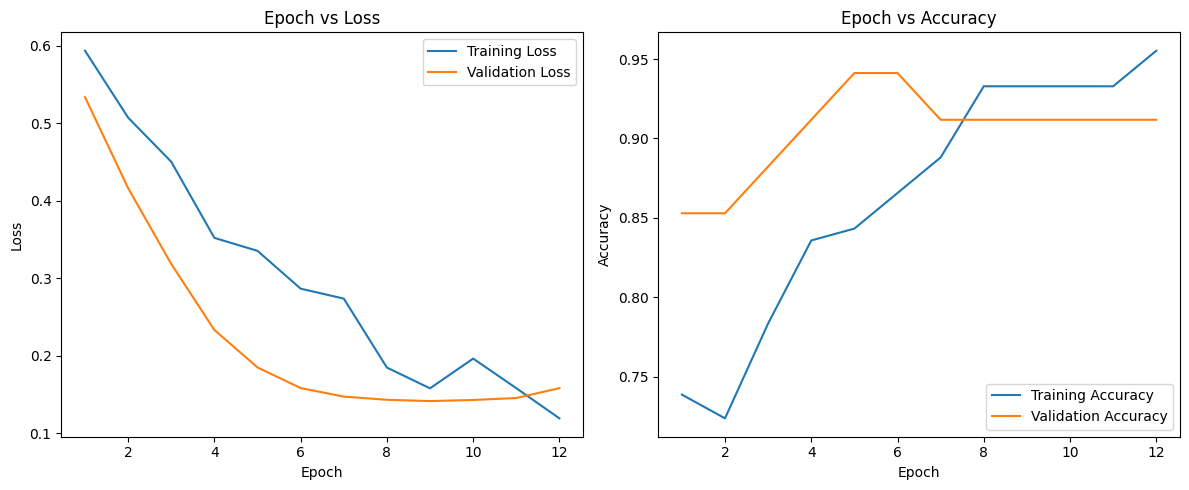

In [37]:
# Plotting Epoch vs Loss and Accuracy
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, test_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Classification Matrix and Classification Report

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

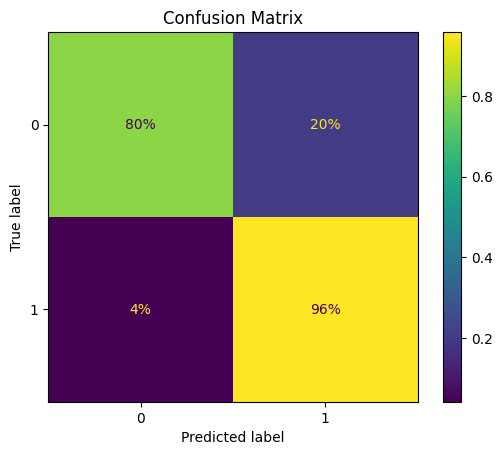

In [39]:
# Ensure model is in evaluation mode and make predictions on test data
model.eval()
y_pred = []

with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_pred.extend(outputs.cpu().round().numpy())  # Move predictions to CPU and round to binary

# Convert predictions and true labels to the correct format
y_pred = [int(pred[0]) for pred in y_pred]  # Flatten list of predictions
y_test_binary = y_test_tensor.cpu().numpy().astype(int).flatten()  # Convert y_test_tensor to numpy for compatibility

# Confusion matrix plot
ConfusionMatrixDisplay.from_predictions(
    y_test_binary, y_pred, normalize="true", values_format=".0%"
)
plt.title("Confusion Matrix")
plt.show()

In [40]:
# Classification report
print("Classification Report:")
print(classification_report(y_test_binary, y_pred, target_names=["Small Cell", "Non-Small Cell"]))

Classification Report:
                precision    recall  f1-score   support

    Small Cell       0.89      0.80      0.84        10
Non-Small Cell       0.92      0.96      0.94        24

      accuracy                           0.91        34
     macro avg       0.90      0.88      0.89        34
  weighted avg       0.91      0.91      0.91        34

